## CNN 卷積神經網路 (convolution, 卷積)

### 基於 MLP 上建構濾鏡 ,在每個濾鏡下做相似特徵判別, 做完特徵提取後壓縮減少運算時間
> 抽取特徵，不用像全連接一樣看全局圖片的特徵(CNN 相較於全連接的好處)
> 基本上是濾鏡矩陣(filter)，對 input 圖片像素矩陣相乘，掃完輸出的縮小矩陣表示了原圖的特徵是否有 filter中的特徵(有在 filter 相乘才會有抽完的特徵，反之則無)
> ex: 4*4 input * 3*3 filter -> output 2*2 filter
> 可以有多個 filter, 一個 filter 輸出一個 feature map, 多個 feature map 可以重疊
> CNN 學習的就是如何訓練抽取特徵的 filter
> weight sharing(用同一個 filter 去抽取, 即共用 weight)
> # convolution -> maxpooling -> convolution ->.........
> Flatten: 將 feature map 矩陣, 平坦展開成一個特徵向量(為了之後作為 input 再接全連接層)

> CNN 學習特徵是從大到小, 學粗略特徵(ex: 線段顏色)到學明顯特定特徵(ex:鳥頭)

> 中間層=> 選 relu,  最後一層如果是多個輸出=> softmax, 一個輸出=> sigmoid

> keras.layers.conv2D(strides=(2,2)) 可以設定 filter 移動的步長

> keras.layers.conv2D(padding=’same’) same->原圖大小是多少, 做 convolution 後輸出也是多少(補0)

> keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None) # MaxPooling-> 輸出後取區域的最大值(特徵圖(feature map),再度縮小取精華)

> convolution -> maxpooling -> convolution ->.........

In [ ]:
from keras.datasets.cifar10 import load_data
(x_train, y_train), (x_test, y_test) = load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [2]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
trans = ["飛機", "汽車", "鳥", "貓", "鹿", "狗", "青蛙",
        "馬", "船", "卡車"]

卡車


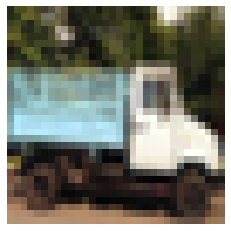

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
c = random.randint(0, 49999)
plt.axis("off")
# trains[0] -> 飛機
# XX -> trains[[0]]
category = y_train[c][0]
print(trans[category])
plt.imshow(x_train[c])

In [5]:
# 資料預處理
# 1. 題目預處理(Normalize), 讓不同特徵重要度等值
# Keras 在準備隨機那組 weight, 跟 Normalize 的圖片比較搭
# 卷積 CNN 不需要攤開 reshape-> 直接 Input, 本來就需要處理周圍維度特徵判斷 
x_train_shape = x_train / 255 # 6萬筆, 28*28=784個像素
x_test_shape = x_test / 255
x_train_shape[0]
# print(len(x_train_shape[0])) # 784

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

In [6]:
# 2. 答案預處理(one-hot encoding)
# 希望的樣子: [P0..., ..P9] 對應0~9每個數字可能的機率
# 可能輸出: [0,0,0.2,0,0, 0.8,0,0,0,0]
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print("原來: ", y_train[1])
print("後來: ", y_train_cat[1])

原來:  [9]
後來:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [7]:
from keras.models import Sequential
# MLP
from keras.layers import Dense, Flatten
# Conv
from keras.layers import Conv2D, MaxPooling2D
# keras.layers.conv2D(strides=(2,2)) 可以設定 filter 移動的步長
# keras.layers.conv2D(padding=’same’) same->原圖大小是多少, 做 convolution 後輸出也是多少(補0)
# keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None) # MaxPooling-> 輸出後取區域的最大值(特徵圖(feature map),再度縮小取精華)
# convolution -> maxpooling -> convolution ->.........

cnn = Sequential()
# Output Shape=>(None, 32, 32, 32), 寬/高/通道數(過濾器32個)  
# Param 896 = 3 * 3的 filter * 3 RGB * 32 個 filter + 32 個 bias(一個 activation 配一個)
# (一個過濾器) 3 * 3 * 3 * (filter數目) 32 + (bias)32 = 896 
cnn.add(Conv2D(32, (3, 3), 
               input_shape=(32, 32, 3),
               padding="same",
               activation="relu")) # 過濾器數目, kernal濾鏡(卷積窗大小), padding="same" 外面補一圈後大小一致
cnn.add(MaxPooling2D(pool_size=(2, 2))) # Output Shape=> 寬高縮小成 16
# (一個過濾) 3 * 3 * 32(被放大的特徵) * (filter 數目) 64 + (bias) 64 = 18496
cnn.add(Conv2D(64, (3, 3), # keras.layers.conv2D(filters=數量, kernel_size=filter大小)
               padding="same",
               activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, (3, 3), 
               padding="same",
               activation="relu")) # 由3個 RGB 不斷擴充成 128個特徵(角度)
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten()) # 平坦化成一維 2048 個特徵
cnn.add(Dense(256, activation="relu"))
cnn.add(Dense(10, activation="softmax")) # 256*10+10=2570
cnn.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [0]:
# 確定模型訓練方式...等
# 隨機(隨便選一組 weight)梯度(正確方向)下降 
# loss: 最後輸出一個, 選: binary_crossentropy  亂度距離, 最後輸出多個: categorical_crosentropy
# optimizer: 下降的時候如何優化 -> 基於動量(走得時候不是等速, 有速度的累積)
cnn.compile(loss="categorical_crossentropy",
            metrics=["accuracy"],
            optimizer="adam")

In [9]:
# batch: 看幾筆(200) 做一次梯度下降(修正)
# epochs: 整份考古題看幾次(10)
# 5個 epochs, 200 batch(修正頻率): 60000筆 * 10epochs/200batch -> 3000(次), validation_split 驗證集切分
cnn.fit(x_train_shape, 
        y_train_cat, 
        batch_size=200, 
        epochs=10, 
        validation_split=0.1)
# 主要看 val_loss, 有沒有趨近平滑

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 10s 220us/step - loss: 1.6137 - accuracy: 0.4173 - val_loss: 1.4041 - val_accuracy: 0.4998
Epoch 2/10
45000/45000 [==============================] - 3s 62us/step - loss: 1.2239 - accuracy: 0.5666 - val_loss: 1.0669 - val_accuracy: 0.6334
Epoch 3/10
45000/45000 [==============================] - 3s 62us/step - loss: 1.0353 - accuracy: 0.6360 - val_loss: 0.9812 - val_accuracy: 0.6612
Epoch 4/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.9236 - accuracy: 0.6798 - val_loss: 0.8878 - val_accuracy: 0.6924
Epoch 5/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.8236 - accuracy: 0.7146 - val_loss: 0.8727 - val_accuracy: 0.7022
Epoch 6/10
45000/45000 [==============================] - 3s 63us/step - loss: 0.7511 - accuracy: 0.7397 - val_loss: 0.8555 - val_accuracy: 0.6992
Epoch 7/10
45000/45000 [==============================] - 3s 62us/s

In [10]:
cnn.evaluate(x_test_shape, y_test_cat)

10000/10000 [==============================] - 1s 99us/step


[0.8279839147567749, 0.7269999980926514]

In [12]:
import pandas as pd
# predict: 機率 predict_classes: 分類
# trans = ["飛機", "汽車", "鳥", "貓", "鹿", "狗", "青蛙",
#         "馬", "船", "卡車"]
pre = cnn.predict_classes(x_test_shape)
pre
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

,0,1,2,3,4,5,6,7,8,9
0,765,8,75,9,12,8,5,20,56,42
1,24,807,12,4,5,4,4,7,23,110
2,48,8,678,28,89,59,23,49,11,7
3,16,10,130,441,70,191,39,65,15,23
4,15,3,93,43,682,37,20,95,11,1
5,11,4,72,93,44,664,17,84,4,7
6,7,2,79,51,70,31,728,15,8,9
7,8,1,37,15,36,47,1,839,2,14
8,50,27,21,10,5,6,3,9,840,29
9,30,61,14,11,4,13,4,17,20,826


In [0]:
# numpy 才能這樣直接每個數字比較
import numpy as np
# list: list(一個數字)
# numpy array: nparray(多個數字)
diff = np.nonzero(pre != y_test)[0]
# 預測錯誤的圖的原本標籤
orifalse = y_test[diff]
# 預測錯誤的圖的預測標籤
prefalse = pre[diff]
# 把圖拿出來
imgfalse = x_test[diff]
# 整張圖的寬高
plt.figure(figsize=(14,40))
# 每個列固定 10 個
width = 10
height = int(len(imgfalse) / 10) + 1
for (i, img) in enumerate(imgfalse):
    # (列數, 行數, 第幾張圖(i開始)
    plt.subplot(height, width, i + 1)
    plt.axis("off")
    t = "[P]:" + str(prefalse[i]) + "[0]:" + str(orifalse[i])
    plt.title(t)
    plt.imshow(img, cmap="gray")

In [13]:
pre

array([5, 8, 8, ..., 5, 4, 7])

In [14]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]])

In [15]:
pre.shape

(10000,)

In [16]:
y_test.shape

(10000, 1)

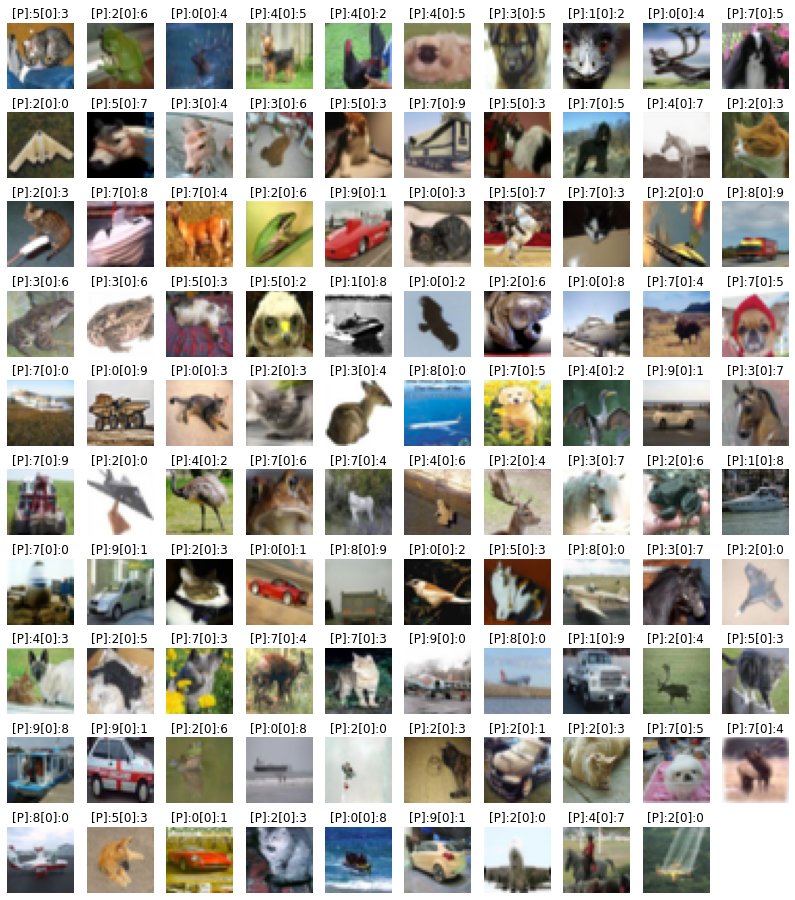

In [18]:
# numpy 才能這樣直接每個數字比較
import numpy as np
# list: list(一個數字)
# numpy array: nparray(多個數字)
y_dim = y_test.reshape(10000)
diff = np.nonzero(pre != y_dim)[0]
# 預測錯誤的圖的原本標籤
orifalse = y_dim[diff]
# 預測錯誤的圖的預測標籤
prefalse = pre[diff]
# 把圖拿出來
imgfalse = x_test[diff]
# 整張圖的寬高
plt.figure(figsize=(14,450))
# 每個列固定 10 個
width = 10
height = int(len(imgfalse) / 10) + 1
for (i, img) in enumerate(imgfalse[0: 99]): # 太多了只印 100 張
    # (列數, 行數, 第幾張圖(i開始)
    plt.subplot(height, width, i + 1)
    plt.axis("off")
    t = "[P]:" + str(prefalse[i]) + "[0]:" + str(orifalse[i])
    plt.title(t)
    plt.imshow(img)